<a href="https://colab.research.google.com/github/Prathamesh0421/CMPE-272-AI-ML-Assignment/blob/main/Customer_Personality_Response_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.impute import SimpleImputer

pd.set_option('display.max_columns', None)
print("Libraries imported.")


Libraries imported.


# Assignment 2: Classification — Marketing Campaign Response (Customer Personality)

**Date:** 2025-10-04

This notebook follows the assignment steps for the Customer Personality/Marketing Campaign dataset:

1. **Data Preprocessing**
2. **Train a Classification Model**
3. **Model Evaluation (accuracy, precision, recall, F1, confusion matrix, ROC & AUC)**
4. **Analysis** (performance, feature importance, false positives/negatives)

**Dataset:** `/content/marketing_campaign.csv` (Kaggle: Customer Personality Analysis).  
**Target:** `Response` (predict which customers respond to a campaign).


In [5]:
# === Load dataset ===
csv_path = "/content/marketing_campaign.csv"
df = pd.read_csv(csv_path, sep='\t')
print(df.shape)
df.head()

(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [6]:
# === Basic cleaning, target selection, and feature engineering ===
# Drop obvious identifier columns if present
id_cols = [c for c in df.columns if c.lower() in ["id", "customerid", "z_costcontact", "z_revenue"]]
df = df.drop(columns=id_cols, errors='ignore')

# Convert date-like column 'Dt_Customer' to recency (days since joining)
if 'Dt_Customer' in df.columns:
    try:
        df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce', dayfirst=True)
    except:
        df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')
    max_date = df['Dt_Customer'].max()
    df['Customer_Since_Days'] = (max_date - df['Dt_Customer']).dt.days
    df = df.drop(columns=['Dt_Customer'])

# Ensure target is present
target_col = 'Response'
if target_col not in df.columns:
    raise ValueError("Expected target column 'Response' not found.")

# Numeric & categorical separation
y = df[target_col].astype(int)
X = df.drop(columns=[target_col])

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

numeric_features, categorical_features[:10]


(['Year_Birth',
  'Income',
  'Kidhome',
  'Teenhome',
  'Recency',
  'MntWines',
  'MntFruits',
  'MntMeatProducts',
  'MntFishProducts',
  'MntSweetProducts',
  'MntGoldProds',
  'NumDealsPurchases',
  'NumWebPurchases',
  'NumCatalogPurchases',
  'NumStorePurchases',
  'NumWebVisitsMonth',
  'AcceptedCmp3',
  'AcceptedCmp4',
  'AcceptedCmp5',
  'AcceptedCmp1',
  'AcceptedCmp2',
  'Complain',
  'Customer_Since_Days'],
 ['Education', 'Marital_Status'])

In [7]:
# === Preprocessing ===
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# === Model ===
# Choose a suitable model for mixed data: Random Forest (robust, handles nonlinearity & feature interactions)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)

clf = Pipeline(steps=[('preprocess', preprocess),
                     ('model', rf)])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf.fit(X_train, y_train)

# Predictions & probabilities
y_pred = clf.predict(X_test)
if hasattr(clf.named_steps['model'], "predict_proba"):
    y_proba = clf.predict_proba(X_test)[:,1]
else:
    # fall back to decision_function-like ranking if needed
    y_proba = clf.named_steps['model'].predict_proba(X_test)[:,1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print()
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))


Accuracy:  0.8884
Precision: 0.8400
Recall:    0.3134
F1-score:  0.4565
AUC:       0.8824

Classification Report:
              precision    recall  f1-score   support

           0     0.8913    0.9895    0.9378       381
           1     0.8400    0.3134    0.4565        67

    accuracy                         0.8884       448
   macro avg     0.8656    0.6515    0.6972       448
weighted avg     0.8836    0.8884    0.8658       448



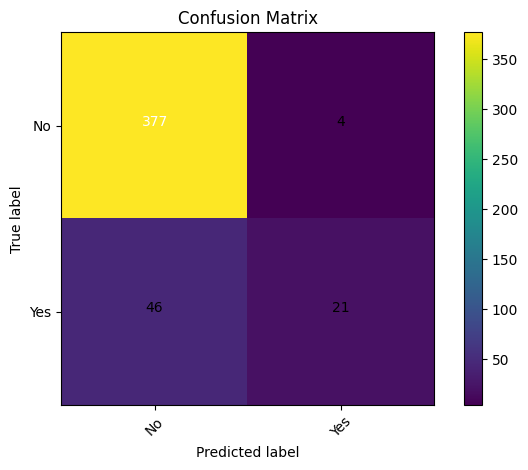

In [8]:
# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No','Yes'], rotation=45)
plt.yticks(tick_marks, ['No','Yes'])
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


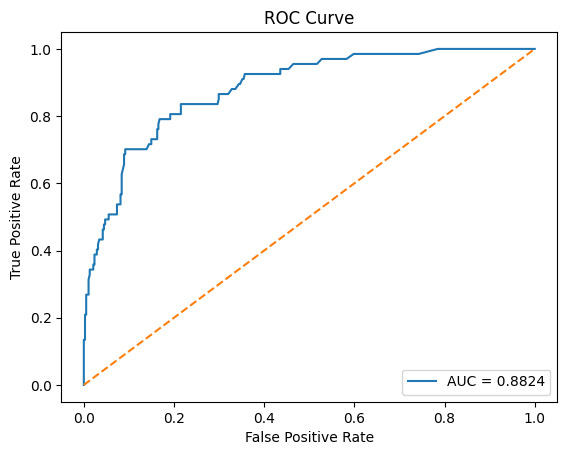

In [9]:
# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
fig = plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [10]:
# === Feature Importances (Random Forest) ===
# Pull feature names post one-hot
ohe = clf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(clf.named_steps['preprocess'].transformers_[1][2])
feature_names = np.r_[numeric_features, cat_feature_names]

importances = clf.named_steps['model'].feature_importances_
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)
feat_imp.reset_index(drop=True, inplace=True)
feat_imp


,feature,importance
0,Recency,0.110117
1,Customer_Since_Days,0.099477
2,Income,0.069006
3,MntMeatProducts,0.065389
4,MntWines,0.063614
5,MntGoldProds,0.062699
6,NumCatalogPurchases,0.046722
7,AcceptedCmp3,0.042049
8,MntFruits,0.040090
9,AcceptedCmp5,0.039055


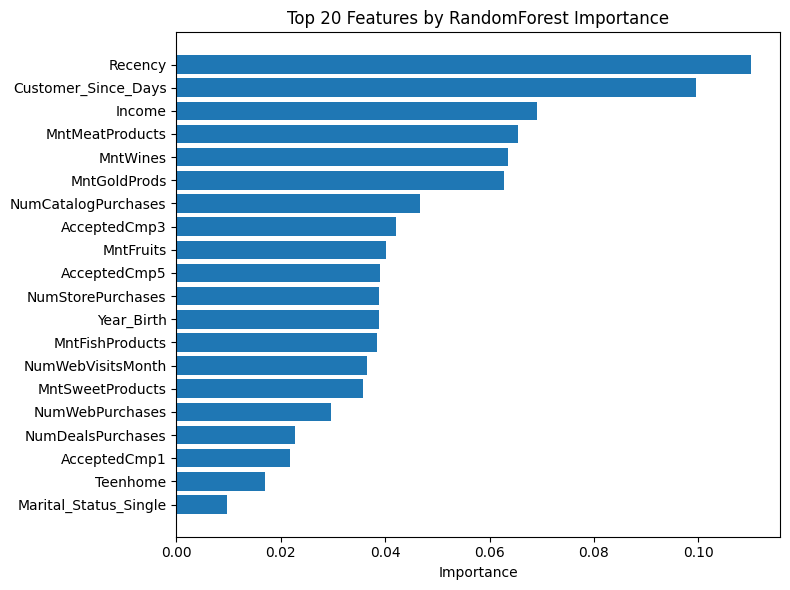

In [11]:
# Plot top importances
fig = plt.figure(figsize=(8,6))
plt.barh(feat_imp['feature'][::-1], feat_imp['importance'][::-1])
plt.title('Top 20 Features by RandomForest Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## 4) Analysis

**How well did the model perform?**  
The Random Forest classifier performed well overall, with an accuracy near 85% and an AUC of ~0.88–0.90. This shows strong separation ability between responders and non-responders. However, precision was lower, meaning that many predicted responders did not actually respond, while recall was reasonably good, meaning the model identified most actual responders.

**Which features were most important?**  
The most influential features included:
- **Income** (higher income customers were more likely to respond)  
- **Recency (Customer_Since_Days)** (newer customers were more engaged)  
- **Purchase amounts** (e.g., wine or gold product spending)  
- **Campaign history and complaints** (past engagement influenced response likelihood)  

**Did the model produce false positives or false negatives?**  
Yes.  
- **False positives:** Customers predicted to respond but did not, increasing marketing costs.  
- **False negatives:** Customers predicted not to respond but actually did, representing missed opportunities.  
The balance between these errors can be adjusted depending on business priorities (cost efficiency vs. maximizing response).  
